# TP 1: Bayesian Linear Regression

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple, Union, Optional
%matplotlib inline

In [2]:
from utils import plot_results

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [3]:
OFFSET = "offset"
SLOPE= "slope"
SIGMA = "sigma"
N = "nbpts"

In [4]:
GROUNDTRUTH = {
    OFFSET: -0.3,
    SLOPE: 0.5,
    SIGMA:0.2, #we assume that we know how to model the noise
    N: 25
}

In [5]:
# GROUNDTRUTH = {
#     OFFSET: -0.8,
#     SLOPE: 0.5,
#     SIGMA:0.1, #we assume that we know how to model the noise
#     N: 30
# }

In [6]:

# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = GROUNDTRUTH["offset"] + GROUNDTRUTH["slope"]*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
nbpts=25
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, GROUNDTRUTH[N])
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=GROUNDTRUTH[SIGMA])
dataset_linear['X_test'] = np.linspace(-10,10, 10*GROUNDTRUTH[N])
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=GROUNDTRUTH[SIGMA])

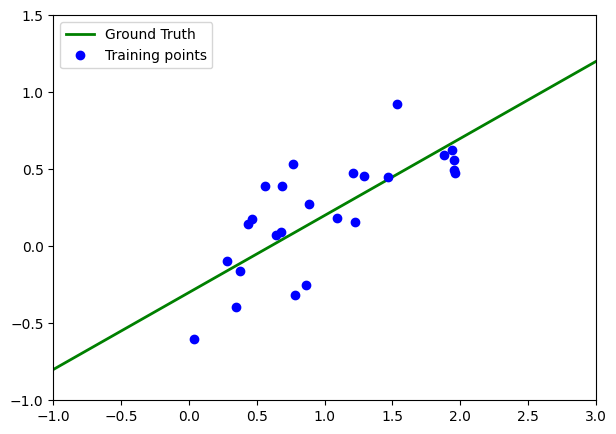

In [7]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [8]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0
dataset_linear['BETA'] = 1/(2.0*GROUNDTRUTH[SIGMA]**2)

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

**Question 1.1: Code linear basis function**

In [9]:
# Define basis function  - keep the features linear (not polynomial, sinus etc...)
# Add a one coordinate to make the transform affine.

def phi_linear(x: float) -> np.ndarray:
    """ Linear Basis Functions 
    
    Args:
      x: (float) 1D input
      
    Returns:
      (array) linear features of x
    """
    return np.stack([np.ones_like(x), x], axis=1)

**Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**

Thanks to the prior and the likelihood both having a normal distribution, the posterior ends up following a Normal distribution.
$$p(w|X, Y) = \mathcal{N}(w|\mu, \Sigma)$$
where
- $\Sigma = \big[\alpha I + \beta \Phi^T \Phi\big]^{-1}$
- $\mu = \beta . \Sigma . \Phi^T. Y$

- If we add more points, the posterior distribution gets narrower (sharper). We get more confidence in this estimator.
- If we set $N=0$ (getting no samples), posterior=prior. 
    - The posterior plot simply looks like a isotropic gaussian, $p(w|\alpha) = \mathcal{N}(w, 0, \frac{1}{\alpha})$ . 
    - When we set a very large $\alpha$ we have a lot of confidence in the prior so we get a narrow spot at (0,0).
    - If $\alpha$ is low, we get low confidence in the priori, the gaussian is widespread.
Note: when $\alpha=0$, $\Sigma$ is the inverse of the covariance matrix of the sample feature vectors.

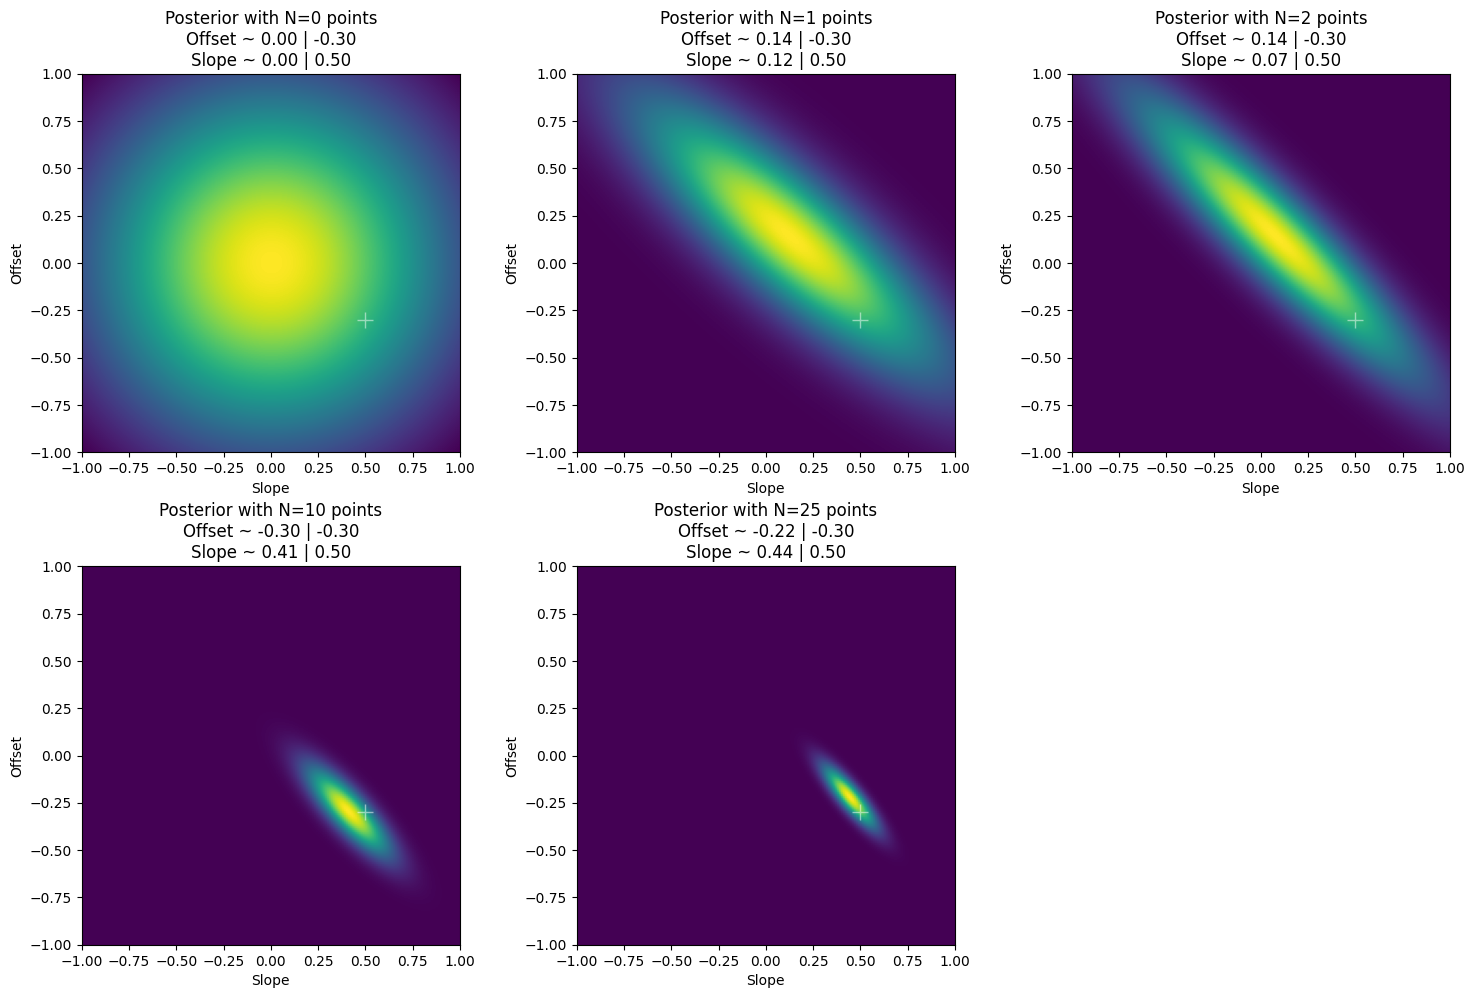

In [10]:
# visualize posterior sampling

# @TODO: several plots depending on alpha
plt.figure(figsize=(15,10))
for count,n in enumerate([0, 1, 2, 10, len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    phi = phi_linear(cur_data)
    phi_T_dot_phi = np.dot(phi.T, phi)
    sigma_inv = dataset_linear['ALPHA']*np.eye(2) + dataset_linear['BETA']*phi_T_dot_phi
    sigma_N = np.linalg.inv(sigma_inv)
    mu_N = dataset_linear['BETA'] *(np.dot(sigma_N ,  np.dot(phi.T, cur_lbl)))
    # Compute values on meshgrid
    sigma_N_inv = np.linalg.inv(sigma_N) # should be ~ sigma_inv

    meshgrid = np.arange(-1, 1.01, 0.01)
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w = np.zeros((2,1))
            w[0,0] = meshgrid[i] #offset - rows - y - vertical
            w[1,0] = meshgrid[j] #slope - columns - x - horizontal
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, sigma_N_inv), (w-mu_N.reshape(2,1))))
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma_N) ))
    posterior[:,:] /= Z
    
    # Plot posterior with n points
    plt.subplot(231+count)
    plt.imshow(posterior, extent=[-1,1,1,-1])  # left, right , bottom, top
    # Do not inverse axes at this point, simply rescale!    
    plt.plot(GROUNDTRUTH[SLOPE], GROUNDTRUTH[OFFSET], '+', markeredgecolor='white', markeredgewidth=1, markersize=12, alpha=0.5)
    plt.gca().invert_yaxis() # Now you can invert the axes
    plt.ylabel("Offset") # y
    plt.xlabel("Slope") # x
    plt.title(f'Posterior with N={n} points\n'+
              f'Offset ~ {mu_N[0]:.2f} | {GROUNDTRUTH[OFFSET]:.2f}\n'+
              f'Slope ~ {mu_N[1]:.2f} | {GROUNDTRUTH[SLOPE]:.2f}')
plt.tight_layout()
plt.show()

**Question 1.3: Recall and code closed form of the predictive distribution in linear case.**

In [11]:
#TO DO: Code closed form solution according to the following requirements defined below

# Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen,
# the training set (X_train, y_train) and the noise precision parameter beta 
# and prior precision parameter alpha chosen.
# It should return a function outputing both mean and std of the predictive distribution at a point x*.

def closed_form(feature_func: Callable, X_train: np.ndarray, y_train: np.ndarray, alpha:float, beta: float) -> Callable:
  """Closed form solution

  Args:
  feature_func: (function) basis function example:
  '''
    def feature_func(x: float) -> np.ndarray:
    return np.stack([np.ones_like(x), x], axis=1)
  '''

  X_train: (array) train inputs, sized [N,].
  y_train: (array) train labels, sized [N, ].
  alpha: (float) prior precision parameter.
  beta: (float) noise precision parameter.
  
  Returns:
    (function) prediction function, returning itself both mean and std
  """
  cur_data = X_train
  cur_lbl = y_train
  phi_data = feature_func(cur_data)
  phi_T_dot_phi = np.dot(phi_data.T, phi_data)
  feat_dim = phi_data.shape[1]
  print(feat_dim)
  sigma_inv = alpha*np.eye(feat_dim) + beta*phi_T_dot_phi
  sigma_N = np.linalg.inv(sigma_inv)
  mu_N = beta *(np.dot(sigma_N ,  np.dot(phi_data.T, cur_lbl)))
  def predictive_distribution_gaussian_model(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Predictive Gaussian distribution evaluated at "x*" determined by its average and standard deviation

    Args:
        x (np.ndarray): _description_

    Returns:
        Tuple[np.ndarray, np.ndarray]: mean, standard deviation evaluated at x star
    """
    phi = feature_func(x)
    mean_value = np.dot(phi, mu_N)
    dist_squared  = np.einsum('ij,jk,ik->i', phi, sigma_N, phi)
    # Einsum use to save some computation here
    # dist_squared_big  = np.dot(np.dot(phi, sigma_N), phi.T).diagonal()
    # assert np.allclose(dist_squared_big, dist_squared)
    variance = 1./beta + dist_squared
    std_dev = np.sqrt(variance)
    return mean_value, std_dev

  return predictive_distribution_gaussian_model


# avg, std = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'], 
#                      dataset_linear['ALPHA'], dataset_linear['BETA'])(dataset_linear['X_test'])

**Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**

2


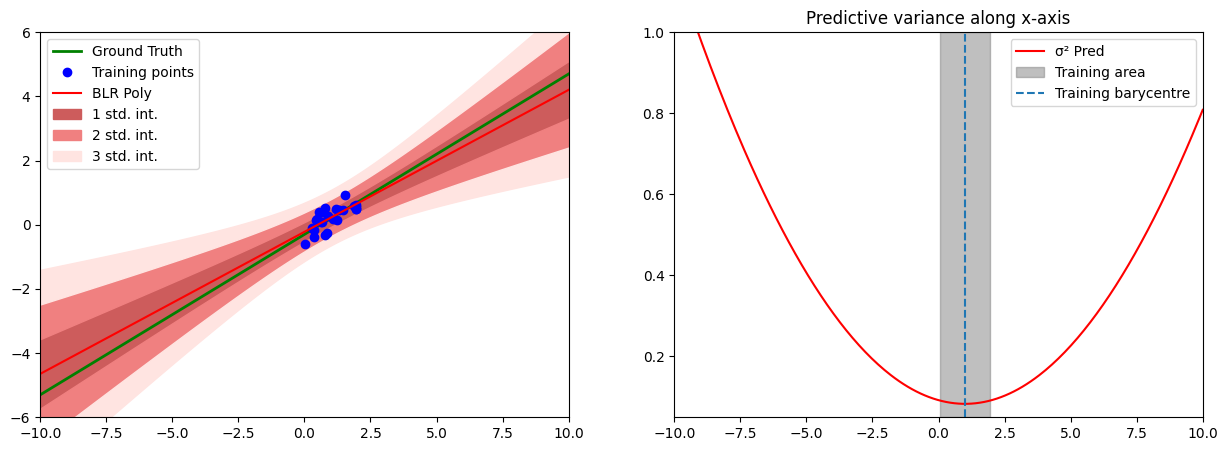

In [12]:
# Predict on test dataset and visualize results
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'], 
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

y_pred, y_pred_std = f_pred(dataset_linear['X_test'])

plot_results(
    dataset_linear['X_train'], dataset_linear['y_train'],
    dataset_linear['X_test'], dataset_linear['y_test'],
    y_pred, y_pred_std,
    xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1
)

**Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

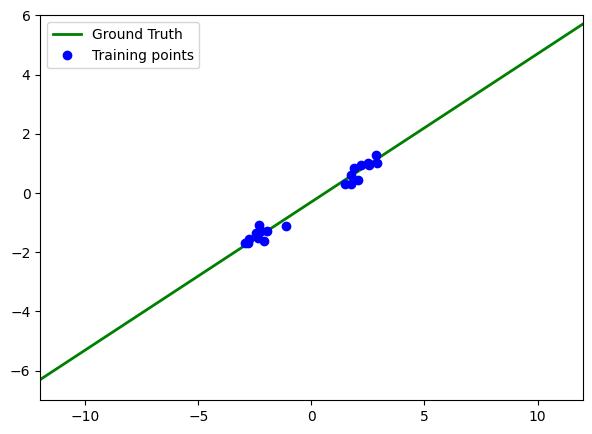

In [13]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0 ,sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()


f_pred_holes = closed_form(
    phi_linear,
    dataset_hole['X_train'], dataset_hole['y_train'],
    dataset_hole['ALPHA'], dataset_hole['BETA'])

y_pred_hole, y_pred_std_hole  = f_pred_holes(dataset_hole['X_test'])
plot_results( dataset_hole['X_train'], dataset_hole['y_train'], dataset_hole['X_test'],dataset_hole['y_test'], y_pred_hole, y_pred_std_hole, xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5)

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

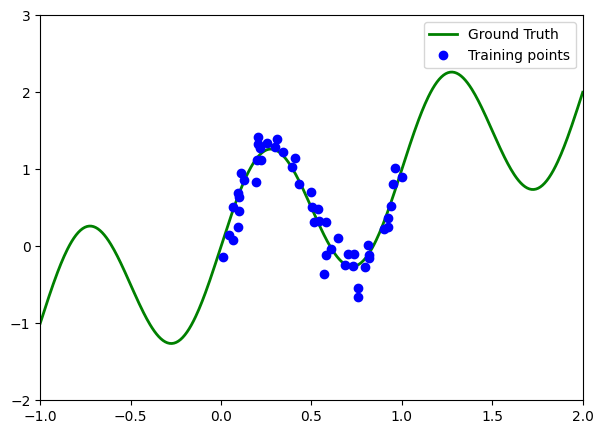

In [15]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
sigma=0.2
nbpts=50
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=sigma)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*nbpts)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=sigma)

dataset_sinus['ALPHA'] = 0.05
dataset_sinus['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()


### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [20]:
# Define basis function
def phi_polynomial(x: np.ndarray):
    """ Polynomial Basis Functions up to degree D-1
    
    Args:
      x: (float) 1D input
      
    Returns:
      (array) polynomial features of x
    """
    D = 10
    exponentiated = [x**d for d in range(2, D)]
    poly_feats = np.stack([np.ones_like(x), x, *exponentiated], axis=1)
    print(x.shape, poly_feats.shape)
    return poly_feats

**Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**

(50,) (50, 10)
10
(500,) (500, 10)


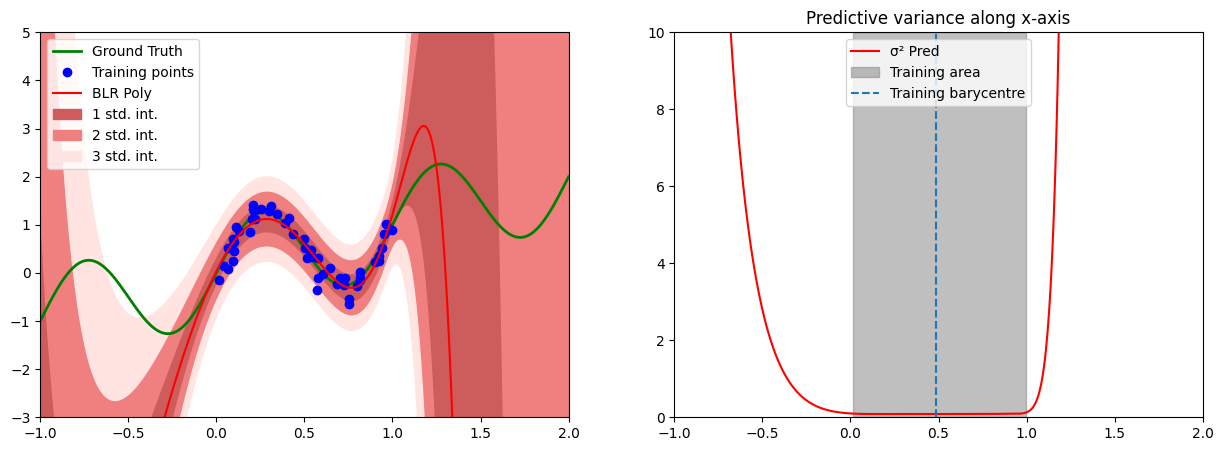

In [17]:
f_pred = closed_form(
    phi_polynomial,
    dataset_sinus['X_train'], dataset_sinus['y_train'], 
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

y_pred, y_pred_std = f_pred(dataset_sinus['X_test'])

plot_results(
    dataset_sinus['X_train'], dataset_sinus['y_train'],
    dataset_sinus['X_test'], dataset_sinus['y_test'],
    y_pred, y_pred_std,
    xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10
)

### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_M)$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_M(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_n) & \phi_1(x_n) &... &\phi_M(x_n)
  \end{bmatrix}
$$

**Question 2.3: Code gaussian basis function**

In [18]:
#TO DO: Define Gaussian basis function
MU_MIN = 0
MU_MAX = 1
M = 9

def phi_gaussian(x) :
    """Gaussian Basis Functions
    
    Args:
      x: (float) 1D input
      
    Returns:
      (array) gaussian features of x
    """
    s = (MU_MAX-MU_MIN)/M
    print(x.shape, np.arange(MU_MIN, MU_MAX, s).shape)
    mean_range = np.arange(MU_MIN, MU_MAX, s)
    diferences  = np.expand_dims(x, axis=1) - np.expand_dims(mean_range, axis=0).repeat(x.shape, axis=0)
    return np.exp(-(diferences)** 2 / (2 * s * s))

**Question 2.4 : Code and visualize results on sinusoidal dataset using Gaussian basis functions. What can you say this time about the predictive variance?**

(50,) (9,)
9
(500,) (9,)


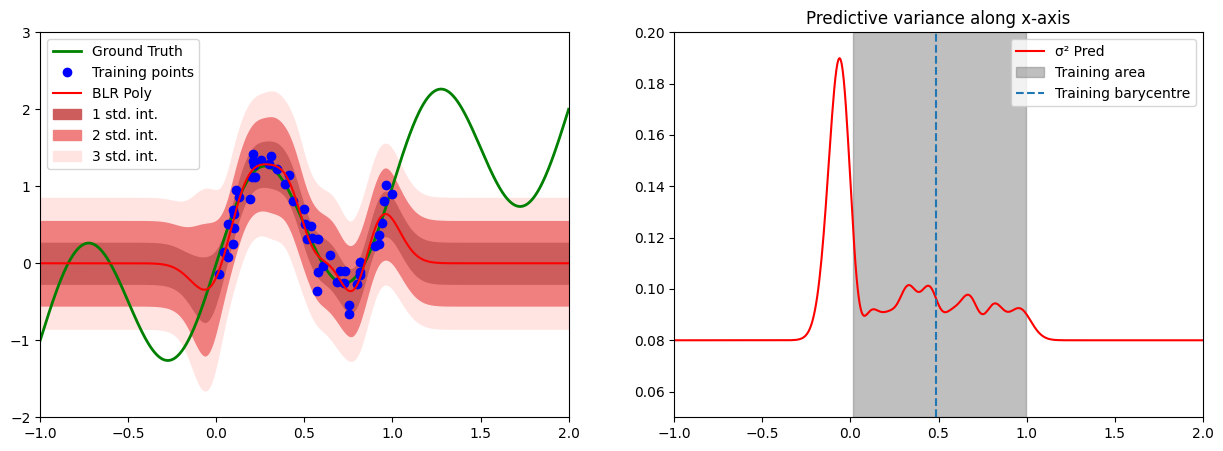

In [19]:
f_pred = closed_form(
    phi_gaussian,
    dataset_sinus['X_train'], dataset_sinus['y_train'], 
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

y_pred, y_pred_std = f_pred(dataset_sinus['X_test'])

plot_results(
    dataset_sinus['X_train'], dataset_sinus['y_train'],
    dataset_sinus['X_test'], dataset_sinus['y_test'],
    y_pred, y_pred_std,
    xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2
)

**Question 2.5: Explain why in regions far from training distribution, the predictive variance converges to this value when using localized basis functions such as Gaussians.**